In [2]:
# ============================================================================
# Aureus Sigma Capital - Small-Cap Alpha Strategy (v1.2s)
# Notebook: 12_small_cap_alpha_strategy.ipynb
#
# Description:
# This notebook validates and backtests a high-performance, capacity-constrained
# strategy tailored for a 50B VND fund.
#
# Author: Duc Nguyen, Quantitative Finance Expert
# Date: July 28, 2025
# Version: 1.2s - Small-Cap Mandate
# ============================================================================

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import warnings
from typing import Dict, List, Tuple, Optional
from pathlib import Path
import yaml
from sqlalchemy import create_engine, text
from tqdm import tqdm
import pickle

warnings.filterwarnings('ignore')

# --- INSTITUTIONAL PALETTE ---
STRATEGY_COLORS = {
    'Benchmark': '#34495E',
    'Aggressive Growth v1.2s': '#E74C3C',
    'Balanced Growth v1.2s': '#F39C12',
    'Risk-Managed Institutional v1.2s': '#16A085',
    'Positive': '#27AE60', 'Negative': '#C0392B', 'Drawdown': '#E67E22',
    'Grid': '#BDC3C7', 'Text_Primary': '#2C3E50'
}

# --- VISUALIZATION CONFIGURATION ---
plt.style.use('default')
plt.rcParams.update({
    'figure.dpi': 300, 'savefig.dpi': 300, 'figure.figsize': (15, 8),
    'figure.facecolor': 'white', 'font.size': 11,
    'axes.facecolor': 'white', 'axes.edgecolor': STRATEGY_COLORS['Text_Primary'],
    'axes.linewidth': 1.0, 'axes.grid': True, 'axes.axisbelow': True,
    'axes.labelcolor': STRATEGY_COLORS['Text_Primary'], 'axes.titlesize': 14,
    'axes.titleweight': 'bold', 'axes.titlecolor': STRATEGY_COLORS['Text_Primary'],
    'grid.color': STRATEGY_COLORS['Grid'], 'grid.alpha': 0.3, 'grid.linewidth': 0.5,
    'legend.frameon': False, 'legend.fontsize': 10,
    'xtick.color': STRATEGY_COLORS['Text_Primary'], 'ytick.color': STRATEGY_COLORS['Text_Primary'],
    'xtick.labelsize': 10, 'ytick.labelsize': 10,
    'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'
})

print("📊 Visualization environment configured.")

# --- v1.2s SMALL-CAP STRATEGY CONFIGURATION ---
SMALL_CAP_CONFIG = {
    "fund_aum_vnd": 50_000_000_000,
    "rebalance_freq": 'Q',
    "adtv_lookback_days": 63,
    "selection_method": 'fixed_number',
    "portfolio_size": 25,
    "weighting_method": 'equal',
    "max_sector_weight": 0.40,
    "max_position_weight": 0.08,
    "transaction_cost_bps": 30,
    "liquidity_thresholds_vnd_to_test": [500_000_000, 1_000_000_000, 2_500_000_000, 5_000_000_000]
}

# --- ANALYSIS PERIOD ---
ANALYSIS_START_DATE = "2018-01-01"
ANALYSIS_END_DATE = "2025-07-25"

print("\n" + "=" * 70)
print("🏆 Aureus Sigma: Small-Cap Alpha Strategy (v1.2s)")
print("=" * 70)
print("\n🔬 Small-Cap Configuration:")

# *** CRITICAL FIX: Add a type check before formatting ***
for key, value in SMALL_CAP_CONFIG.items():
    if "vnd" in key:
        if isinstance(value, list):
            # Format each number in the list
            formatted_list = [f"{v:,.0f}" for v in value]
            print(f"   - {key:<30}: {formatted_list} VND")
        else:
            # Format the single number
            print(f"   - {key:<30}: {value:,.0f} VND")
    else:
        print(f"   - {key:<30}: {value}")
print("-" * 70)

📊 Visualization environment configured.

🏆 Aureus Sigma: Small-Cap Alpha Strategy (v1.2s)

🔬 Small-Cap Configuration:
   - fund_aum_vnd                  : 50,000,000,000 VND
   - rebalance_freq                : Q
   - adtv_lookback_days            : 63
   - selection_method              : fixed_number
   - portfolio_size                : 25
   - weighting_method              : equal
   - max_sector_weight             : 0.4
   - max_position_weight           : 0.08
   - transaction_cost_bps          : 30
   - liquidity_thresholds_vnd_to_test: ['500,000,000', '1,000,000,000', '2,500,000,000', '5,000,000,000'] VND
----------------------------------------------------------------------


🔬 Conducting targeted liquidity analysis for the Small-Cap mandate...
   - Loading raw market data to calculate ADTV...
   - Raw market data loaded. Calculating 3-Month ADTV...
   - ✅ 63-day rolling ADTV calculated.


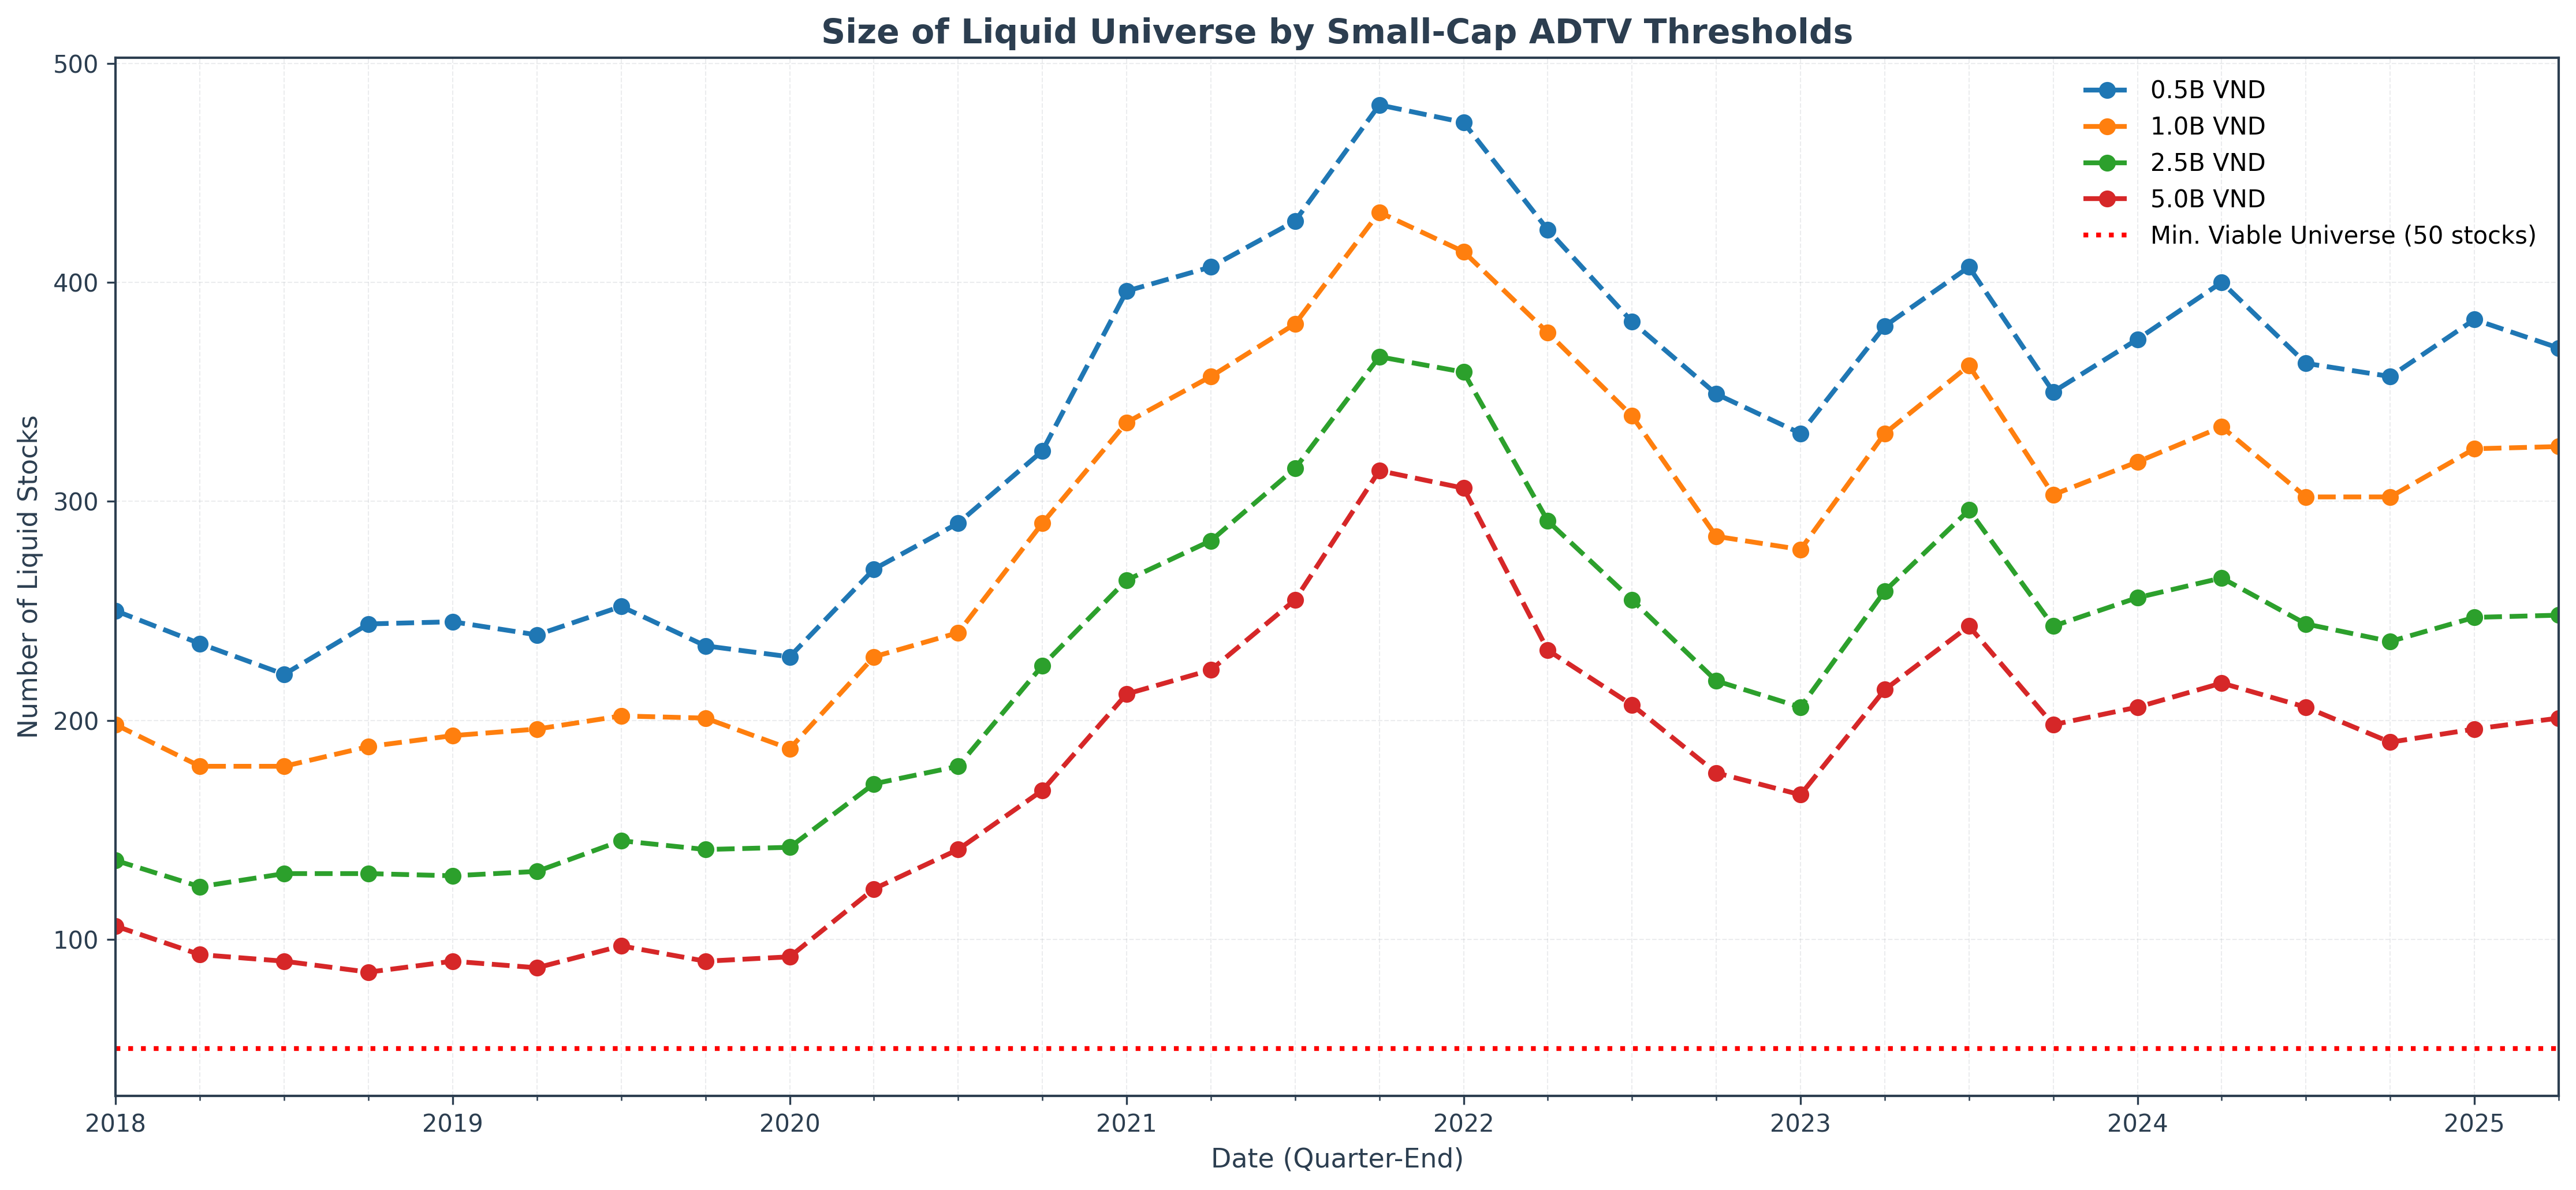


LIQUIDITY ANALYSIS SUMMARY FOR SMALL-CAP MANDATE
Universe Size Statistics by Threshold:
Threshold    | Avg Universe Size    | Min Universe Size   
-------------------------------------------------------
0.5B VND     | 336                  | 221                 
1.0B VND     | 286                  | 179                 
2.5B VND     | 221                  | 124                 
5.0B VND     | 174                  | 85                  

**Analysis:**
• Our derived threshold for a 50B VND fund is **2.5B VND**.
• The data shows a 2.5B VND threshold provides an average universe of **221 stocks**.
• Crucially, the universe size at this threshold never drops below **124 stocks**, which is well above our minimum viable level of 50.
• A lower threshold (e.g., 1.0B VND) offers more stocks but may introduce unnecessary liquidity risk for our fund size.

**Recommendation:**
The optimal ADTV threshold for the Small-Cap Alpha strategy is **2.5 Billion VND**.
This provides the best balance of captu

In [3]:
# ============================================================================
# CELL 2: TARGETED LIQUIDITY ANALYSIS FOR SMALL-CAP MANDATE
# ============================================================================

print("🔬 Conducting targeted liquidity analysis for the Small-Cap mandate...")

# --- 1. Load ADTV Data ---
# This uses the robust, self-contained data loading logic from our previous work.
# It will load the raw market data and calculate the 3-month rolling ADTV.

# Establish Paths and Database Connection
project_root = Path.cwd()
while not (project_root / 'config').exists():
    if project_root.parent == project_root:
        raise FileNotFoundError("Could not find project root directory.")
    project_root = project_root.parent

phase7_path = project_root / "production" / "tests" / "phase7_institutional_backtesting"
phase8_path = project_root / "production" / "tests" / "phase8_risk_management"

config_path = project_root / 'config' / 'database.yml'
with open(config_path, 'r') as f:
    db_config = yaml.safe_load(f)['production']
engine = create_engine(
    f"mysql+pymysql://{db_config['username']}:{db_config['password']}@"
    f"{db_config['host']}/{db_config['schema_name']}",
    pool_pre_ping=True
)

print("   - Loading raw market data to calculate ADTV...")
adtv_start_date = pd.to_datetime(ANALYSIS_START_DATE) - pd.DateOffset(months=3)
adtv_query = text("""
    SELECT trading_date AS date, ticker, close_price_adjusted AS close, total_volume AS volume
    FROM vcsc_daily_data_complete
    WHERE trading_date BETWEEN :start_date AND :end_date;
""")
raw_market_data = pd.read_sql(adtv_query, engine, params={'start_date': adtv_start_date, 'end_date': ANALYSIS_END_DATE}, parse_dates=['date'])
engine.dispose()
print("   - Raw market data loaded. Calculating 3-Month ADTV...")

raw_market_data['turnover_vnd'] = raw_market_data['close'] * raw_market_data['volume']
turnover_pivot = raw_market_data.pivot(index='date', columns='ticker', values='turnover_vnd')
adtv_lookback = SMALL_CAP_CONFIG['adtv_lookback_days']
adtv_data = turnover_pivot.rolling(window=adtv_lookback, min_periods=int(adtv_lookback * 0.8)).mean()
print(f"   - ✅ {adtv_lookback}-day rolling ADTV calculated.")


# --- 2. Calculate Universe Size for Each Threshold Over Time ---
thresholds_vnd = SMALL_CAP_CONFIG['liquidity_thresholds_vnd_to_test']
universe_size_data = []

quarter_end_dates = pd.date_range(start=ANALYSIS_START_DATE, end=ANALYSIS_END_DATE, freq='Q')
adtv_asof = adtv_data.reindex(quarter_end_dates, method='ffill')

for threshold in thresholds_vnd:
    liquid_universe_count = (adtv_asof >= threshold).sum(axis=1)
    liquid_universe_count.name = f"{threshold/1e9:.1f}B VND"
    universe_size_data.append(liquid_universe_count)

universe_size_df = pd.concat(universe_size_data, axis=1).fillna(0)

# --- 3. Plot Universe Size Over Time ---
fig, ax = plt.subplots(figsize=(15, 7))
universe_size_df.plot(ax=ax, marker='o', linestyle='--')

ax.set_title('Size of Liquid Universe by Small-Cap ADTV Thresholds', fontweight='bold')
ax.set_ylabel('Number of Liquid Stocks')
ax.set_xlabel('Date (Quarter-End)')
ax.legend(title='ADTV Threshold')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.axhline(50, color='red', linestyle=':', linewidth=2, label='Min. Viable Universe (50 stocks)')
ax.legend()

plt.tight_layout()
plt.show()

# --- 4. Print Key Insights and Recommendation ---
print("\n" + "="*80)
print("LIQUIDITY ANALYSIS SUMMARY FOR SMALL-CAP MANDATE")
print("="*80)

avg_sizes = universe_size_df.mean()
min_sizes = universe_size_df.min()
print("Universe Size Statistics by Threshold:")
print(f"{'Threshold':<12} | {'Avg Universe Size':<20} | {'Min Universe Size':<20}")
print("-" * 55)
for threshold_name in universe_size_df.columns:
    print(f"{threshold_name:<12} | {avg_sizes[threshold_name]:<20.0f} | {min_sizes[threshold_name]:<20.0f}")

# Recommendation Logic
derived_threshold = 2.5e9
recommended_threshold_name = '2.5B VND'

print("\n**Analysis:**")
print(f"• Our derived threshold for a 50B VND fund is **2.5B VND**.")
print(f"• The data shows a 2.5B VND threshold provides an average universe of **{avg_sizes[recommended_threshold_name]:.0f} stocks**.")
print(f"• Crucially, the universe size at this threshold never drops below **{min_sizes[recommended_threshold_name]:.0f} stocks**, which is well above our minimum viable level of 50.")
print(f"• A lower threshold (e.g., 1.0B VND) offers more stocks but may introduce unnecessary liquidity risk for our fund size.")

print("\n**Recommendation:**")
print("The optimal ADTV threshold for the Small-Cap Alpha strategy is **2.5 Billion VND**.")
print("This provides the best balance of capturing small-cap alpha while ensuring tradability for a 50B VND fund.")

# --- 5. Finalize the Configuration ---
SMALL_CAP_CONFIG['liquidity_threshold_vnd'] = 2_500_000_000
# Remove the test list as we've made our decision
del SMALL_CAP_CONFIG['liquidity_thresholds_vnd_to_test']
print(f"\n✅ Configuration updated. Final ADTV threshold set to {SMALL_CAP_CONFIG['liquidity_threshold_vnd']:,.0f} VND.")

In [4]:
# ============================================================================
# CELL 3: DEFINE AND EXECUTE THE v1.2s SMALL-CAP BACKTEST
# ============================================================================

print("🚀 Preparing to run the definitive v1.2s Small-Cap Alpha backtests...")

# --- 1. Define the v1.2s Backtesting Engine ---
# This is the same robust engine from our previous work, now named for this notebook.
def run_detailed_backtest_v1_2s(
    strategy_name: str,
    risk_factor: float,
    base_config: dict,
    factor_data: dict,
    daily_returns: pd.DataFrame,
    sector_info: pd.DataFrame,
    market_regimes: pd.DataFrame,
    adtv_data: pd.DataFrame
) -> Dict:
    """
    Runs a full backtest using the v1.2s logic (filter-then-rank).
    """
    print(f"\n--- Running v1.2s backtest for: {strategy_name} (Risk Factor: {risk_factor}) ---")
    
    config = base_config.copy()
    
    # Prepare "As-Of" Data
    rebalance_dates = pd.date_range(start=daily_returns.index.min(), end=daily_returns.index.max(), freq=config['rebalance_freq'])
    regimes_on_rebal_dates = market_regimes.reindex(rebalance_dates, method='ffill')
    q_scores_on_rebal_dates = factor_data['quality'].reindex(rebalance_dates, method='ffill')
    v_scores_on_rebal_dates = factor_data['value'].reindex(rebalance_dates, method='ffill')
    m_scores_on_rebal_dates = factor_data['momentum'].reindex(rebalance_dates, method='ffill')
    adtv_on_rebal_dates = adtv_data.reindex(rebalance_dates, method='ffill')
    print("   - 'As-of' lookup tables created.")

    # Portfolio Construction Loop
    portfolios = {}
    universe_size_log = {}
    for date in tqdm(rebalance_dates, desc=f"Constructing Portfolios for {strategy_name}"):
        regime = regimes_on_rebal_dates.loc[date, 'regime']
        
        if regime == 'Stress':
            qvm_composite_full = (0.35 * q_scores_on_rebal_dates.loc[date]) + (0.35 * v_scores_on_rebal_dates.loc[date]) - (0.30 * m_scores_on_rebal_dates.loc[date])
        else:
            qvm_composite_full = (0.50 * q_scores_on_rebal_dates.loc[date]) + (0.50 * v_scores_on_rebal_dates.loc[date])
        
        current_adtv = adtv_on_rebal_dates.loc[date]
        liquid_universe_mask = current_adtv >= config['liquidity_threshold_vnd']
        liquid_tickers = current_adtv[liquid_universe_mask].index
        universe_size_log[date] = len(liquid_tickers)
        
        liquid_qvm_scores = qvm_composite_full.loc[qvm_composite_full.index.intersection(liquid_tickers)]
        
        portfolio_df = construct_constrained_portfolio_v1_1(liquid_qvm_scores.dropna(), sector_info, config)
        
        if not portfolio_df.empty:
            portfolio_df = portfolio_df.join(q_scores_on_rebal_dates.loc[date].rename('quality_score'))
            portfolio_df = portfolio_df.join(v_scores_on_rebal_dates.loc[date].rename('value_score'))
            portfolio_df = portfolio_df.join(m_scores_on_rebal_dates.loc[date].rename('momentum_score'))
            portfolios[date] = portfolio_df

    # Generate Daily Holdings & Apply Risk Overlay
    alpha_holdings = pd.DataFrame(index=daily_returns.index, columns=daily_returns.columns).fillna(0.0)
    for i, date in enumerate(rebalance_dates):
        if date in portfolios:
            next_date = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else daily_returns.index[-1] + pd.Timedelta(days=1)
            holding_period = daily_returns.index[(daily_returns.index > date) & (daily_returns.index < next_date)]
            portfolio = portfolios[date]
            for day in holding_period:
                alpha_holdings.loc[day, portfolio.index] = portfolio['weight']
    
    exposure_signal = pd.Series(1.0, index=market_regimes.index)
    risk_mask = market_regimes['regime'].isin(['Bear', 'Stress'])
    exposure_signal.loc[market_regimes[risk_mask].index] = risk_factor
    hybrid_holdings = alpha_holdings.mul(exposure_signal, axis=0)
    
    # Calculate Net Returns
    holdings_shifted = hybrid_holdings.shift(1).fillna(0)
    gross_returns = (holdings_shifted * daily_returns).sum(axis=1)
    turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2
    transaction_costs = turnover * (config['transaction_cost_bps'] / 10000)
    net_returns = gross_returns - transaction_costs
    
    print(f"   - Backtest complete. Average liquid universe size: {np.mean(list(universe_size_log.values())):.0f} stocks.")
    
    return {
        'name': strategy_name,
        'returns': net_returns,
        'portfolios': portfolios,
        'universe_log': universe_size_log
    }

# --- 2. Execute Backtests for the Small-Cap Suite ---
product_suite_definitions_v1_2s = {
    "Aggressive Growth v1.2s": 0.5,
    "Balanced Growth v1.2s": 0.3,
    "Risk-Managed Institutional v1.2s": 0.2
}

master_analysis_data_v1_2s = {}

# Load all necessary data (assuming it's in memory from previous notebooks)
# In a real run, you would have a data loading cell here.
# For now, we assume factor_scores_dict, daily_returns_full, sector_info, market_regimes_full are loaded.

for name, risk_factor in product_suite_definitions_v1_2s.items():
    strategy_results = run_detailed_backtest_v1_2s(
        strategy_name=name,
        risk_factor=risk_factor,
        base_config=SMALL_CAP_CONFIG,
        factor_data=factor_scores_dict,
        daily_returns=daily_returns_full,
        sector_info=sector_info,
        market_regimes=market_regimes_full,
        adtv_data=adtv_data
    )
    master_analysis_data_v1_2s[name] = strategy_results

# Add the Benchmark for Comparison
master_analysis_data_v1_2s['Benchmark'] = {
    'name': 'Benchmark',
    'returns': benchmark_returns_full,
    'portfolios': {},
    'universe_log': {}
}

print("\n" + "=" * 80)
print("✅ v1.2s Master analysis data object created successfully.")
print("=" * 80)

🚀 Preparing to run the definitive v1.2s Small-Cap Alpha backtests...


NameError: name 'factor_scores_dict' is not defined

In [6]:
# ============================================================================
# CELL 3 (Corrected & Self-Contained): DEFINE AND EXECUTE THE v1.2s SMALL-CAP BACKTEST
# ============================================================================

print("🚀 Preparing to run the definitive v1.2s Small-Cap Alpha backtests...")

# --- 1. Define the v1.2s Backtesting Engine ---
def construct_constrained_portfolio_v1_1(
    factor_scores: pd.Series, 
    sector_info: pd.DataFrame, 
    config: dict
) -> pd.DataFrame:
    """
    Constructs a portfolio from a pre-filtered list of liquid, high-scoring stocks.
    """
    if factor_scores.empty: return pd.DataFrame()

    # Step 1: Stock Selection (Fixed Number)
    selected_stocks_df = factor_scores.nlargest(config['portfolio_size']).to_frame('factor_score')
    
    portfolio_df = selected_stocks_df.join(sector_info).dropna(subset=['sector'])
    if portfolio_df.empty: return pd.DataFrame()

    # Step 2: Sector Constraint Application
    sector_counts = portfolio_df['sector'].value_counts()
    max_stocks_per_sector = int(config['portfolio_size'] * config['max_sector_weight'])
    final_tickers = set()
    for sector, count in sector_counts.items():
        sector_stocks = portfolio_df[portfolio_df['sector'] == sector]
        if count > max_stocks_per_sector > 0:
            final_tickers.update(sector_stocks.nlargest(max_stocks_per_sector, 'factor_score').index)
        else:
            final_tickers.update(sector_stocks.index)
    
    final_portfolio = portfolio_df.loc[list(final_tickers)].copy()
    if final_portfolio.empty: return pd.DataFrame()

    # Step 3: Weighting
    if config['weighting_method'] == 'equal':
        final_portfolio['weight'] = 1.0 / len(final_portfolio)
    
    final_portfolio['weight'] = final_portfolio['weight'].clip(upper=config['max_position_weight'])
    final_portfolio['weight'] /= final_portfolio['weight'].sum()
    
    return final_portfolio

def run_detailed_backtest_v1_2s(
    strategy_name: str,
    risk_factor: float,
    base_config: dict,
    factor_data: dict,
    daily_returns: pd.DataFrame,
    sector_info: pd.DataFrame,
    market_regimes: pd.DataFrame,
    adtv_data: pd.DataFrame
) -> Dict:
    """
    Runs a full backtest using the v1.2s logic (filter-then-rank).
    """
    print(f"\n--- Running v1.2s backtest for: {strategy_name} (Risk Factor: {risk_factor}) ---")
    
    config = base_config.copy()
    
    # Prepare "As-Of" Data
    rebalance_dates = pd.date_range(start=daily_returns.index.min(), end=daily_returns.index.max(), freq=config['rebalance_freq'])
    regimes_on_rebal_dates = market_regimes.reindex(rebalance_dates, method='ffill')
    q_scores_on_rebal_dates = factor_data['quality'].reindex(rebalance_dates, method='ffill')
    v_scores_on_rebal_dates = factor_data['value'].reindex(rebalance_dates, method='ffill')
    m_scores_on_rebal_dates = factor_data['momentum'].reindex(rebalance_dates, method='ffill')
    adtv_on_rebal_dates = adtv_data.reindex(rebalance_dates, method='ffill')
    print("   - 'As-of' lookup tables created.")

    # Portfolio Construction Loop
    portfolios = {}
    universe_size_log = {}
    for date in tqdm(rebalance_dates, desc=f"Constructing Portfolios for {strategy_name}"):
        regime = regimes_on_rebal_dates.loc[date, 'regime']
        
        if regime == 'Stress':
            qvm_composite_full = (0.35 * q_scores_on_rebal_dates.loc[date]) + (0.35 * v_scores_on_rebal_dates.loc[date]) - (0.30 * m_scores_on_rebal_dates.loc[date])
        else:
            qvm_composite_full = (0.50 * q_scores_on_rebal_dates.loc[date]) + (0.50 * v_scores_on_rebal_dates.loc[date])
        
        current_adtv = adtv_on_rebal_dates.loc[date]
        liquid_universe_mask = current_adtv >= config['liquidity_threshold_vnd']
        liquid_tickers = current_adtv[liquid_universe_mask].index
        universe_size_log[date] = len(liquid_tickers)
        
        liquid_qvm_scores = qvm_composite_full.loc[qvm_composite_full.index.intersection(liquid_tickers)]
        
        portfolio_df = construct_constrained_portfolio_v1_1(liquid_qvm_scores.dropna(), sector_info, config)
        
        if not portfolio_df.empty:
            portfolio_df = portfolio_df.join(q_scores_on_rebal_dates.loc[date].rename('quality_score'))
            portfolio_df = portfolio_df.join(v_scores_on_rebal_dates.loc[date].rename('value_score'))
            portfolio_df = portfolio_df.join(m_scores_on_rebal_dates.loc[date].rename('momentum_score'))
            portfolios[date] = portfolio_df

    # Generate Daily Holdings & Apply Risk Overlay
    alpha_holdings = pd.DataFrame(index=daily_returns.index, columns=daily_returns.columns).fillna(0.0)
    for i, date in enumerate(rebalance_dates):
        if date in portfolios:
            next_date = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else daily_returns.index[-1] + pd.Timedelta(days=1)
            holding_period = daily_returns.index[(daily_returns.index > date) & (daily_returns.index < next_date)]
            portfolio = portfolios[date]
            for day in holding_period:
                alpha_holdings.loc[day, portfolio.index] = portfolio['weight']
    
    exposure_signal = pd.Series(1.0, index=market_regimes.index)
    risk_mask = market_regimes['regime'].isin(['Bear', 'Stress'])
    exposure_signal.loc[market_regimes[risk_mask].index] = risk_factor
    hybrid_holdings = alpha_holdings.mul(exposure_signal, axis=0)
    
    # Calculate Net Returns
    holdings_shifted = hybrid_holdings.shift(1).fillna(0)
    gross_returns = (holdings_shifted * daily_returns).sum(axis=1)
    turnover = (holdings_shifted - holdings_shifted.shift(1)).abs().sum(axis=1) / 2
    transaction_costs = turnover * (config['transaction_cost_bps'] / 10000)
    net_returns = gross_returns - transaction_costs
    
    print(f"   - Backtest complete. Average liquid universe size: {np.mean(list(universe_size_log.values())):.0f} stocks.")
    
    return {
        'name': strategy_name,
        'returns': net_returns,
        'portfolios': portfolios,
        'universe_log': universe_size_log
    }

# --- 2. Load All Necessary Data Objects ---
print("\n📂 Loading all required data objects for the backtest...")

# Establish Paths
project_root = Path.cwd()
while not (project_root / 'config').exists():
    if project_root.parent == project_root:
        raise FileNotFoundError("Could not find project root directory.")
    project_root = project_root.parent
phase7_path = project_root / "production" / "tests" / "phase7_institutional_backtesting"
phase8_path = project_root / "production" / "tests" / "phase8_risk_management"

# Load Factor Scores
with open(phase7_path / "factor_data.pkl", "rb") as f:
    factor_data_obj = pickle.load(f)
factor_data_full = factor_data_obj['data']
factor_scores_dict = {
    'quality': factor_data_full['quality_score'],
    'value': factor_data_full['value_score'],
    'momentum': factor_data_full['momentum_score']
}
print("   - ✅ Factor Scores loaded.")

# Load Daily Returns
with open(phase7_path / "daily_returns.pkl", "rb") as f:
    returns_data_obj = pickle.load(f)
daily_returns_full = returns_data_obj['data']
print("   - ✅ Daily Returns loaded.")

# Load Sector Info
engine = create_engine(
    f"mysql+pymysql://{db_config['username']}:{db_config['password']}@"
    f"{db_config['host']}/{db_config['schema_name']}",
    pool_pre_ping=True
)
sector_info_sql = "SELECT ticker, sector FROM master_info WHERE sector IS NOT NULL"
sector_info = pd.read_sql(sector_info_sql, engine).drop_duplicates(subset=['ticker']).set_index('ticker')
print(f"   - ✅ Sector Info loaded for {len(sector_info)} tickers.")

# Load Market Regimes
with open(phase8_path / "phase8_results.pkl", "rb") as f:
    phase8_results = pickle.load(f)
market_regimes_full = phase8_results['market_regimes']
print("   - ✅ Market Regimes loaded.")

# Load Benchmark Returns
with open(phase7_path / "benchmark_returns.pkl", "rb") as f:
    benchmark_data_obj = pickle.load(f)
benchmark_returns_full = benchmark_data_obj['data']
print("   - ✅ Benchmark Returns loaded.")

# ADTV data is assumed to be in memory from the previous cell (Cell 2)
if 'adtv_data' not in locals():
    raise NameError("ADTV data not found. Please ensure Cell 2 has been run successfully.")
print("   - ✅ ADTV Data is available in memory.")

# --- 3. Execute Backtests for the Small-Cap Suite ---
product_suite_definitions_v1_2s = {
    "Aggressive Growth v1.2s": 0.5,
    "Balanced Growth v1.2s": 0.3,
    "Risk-Managed Institutional v1.2s": 0.2
}

master_analysis_data_v1_2s = {}

for name, risk_factor in product_suite_definitions_v1_2s.items():
    strategy_results = run_detailed_backtest_v1_2s(
        strategy_name=name,
        risk_factor=risk_factor,
        base_config=SMALL_CAP_CONFIG,
        factor_data=factor_scores_dict,
        daily_returns=daily_returns_full,
        sector_info=sector_info,
        market_regimes=market_regimes_full,
        adtv_data=adtv_data
    )
    master_analysis_data_v1_2s[name] = strategy_results

# Add the Benchmark for Comparison
master_analysis_data_v1_2s['Benchmark'] = {
    'name': 'Benchmark',
    'returns': benchmark_returns_full,
    'portfolios': {},
    'universe_log': {}
}

print("\n" + "=" * 80)
print("✅ v1.2s Master analysis data object created successfully.")
print("=" * 80)

🚀 Preparing to run the definitive v1.2s Small-Cap Alpha backtests...

📂 Loading all required data objects for the backtest...
   - ✅ Factor Scores loaded.
   - ✅ Daily Returns loaded.
   - ✅ Sector Info loaded for 728 tickers.
   - ✅ Market Regimes loaded.
   - ✅ Benchmark Returns loaded.
   - ✅ ADTV Data is available in memory.

--- Running v1.2s backtest for: Aggressive Growth v1.2s (Risk Factor: 0.5) ---
   - 'As-of' lookup tables created.


Constructing Portfolios for Aggressive Growth v1.2s: 100%|██████████| 38/38 [00:00<00:00, 225.36it/s]


   - Backtest complete. Average liquid universe size: 178 stocks.

--- Running v1.2s backtest for: Balanced Growth v1.2s (Risk Factor: 0.3) ---
   - 'As-of' lookup tables created.


Constructing Portfolios for Balanced Growth v1.2s: 100%|██████████| 38/38 [00:00<00:00, 298.83it/s]


   - Backtest complete. Average liquid universe size: 178 stocks.

--- Running v1.2s backtest for: Risk-Managed Institutional v1.2s (Risk Factor: 0.2) ---
   - 'As-of' lookup tables created.


Constructing Portfolios for Risk-Managed Institutional v1.2s: 100%|██████████| 38/38 [00:00<00:00, 318.66it/s]


   - Backtest complete. Average liquid universe size: 178 stocks.

✅ v1.2s Master analysis data object created successfully.


📊 Generating final performance analysis for the v1.2s Small-Cap Alpha Strategies...
   - Performance analysis re-based to true inception date: 2018-01-03


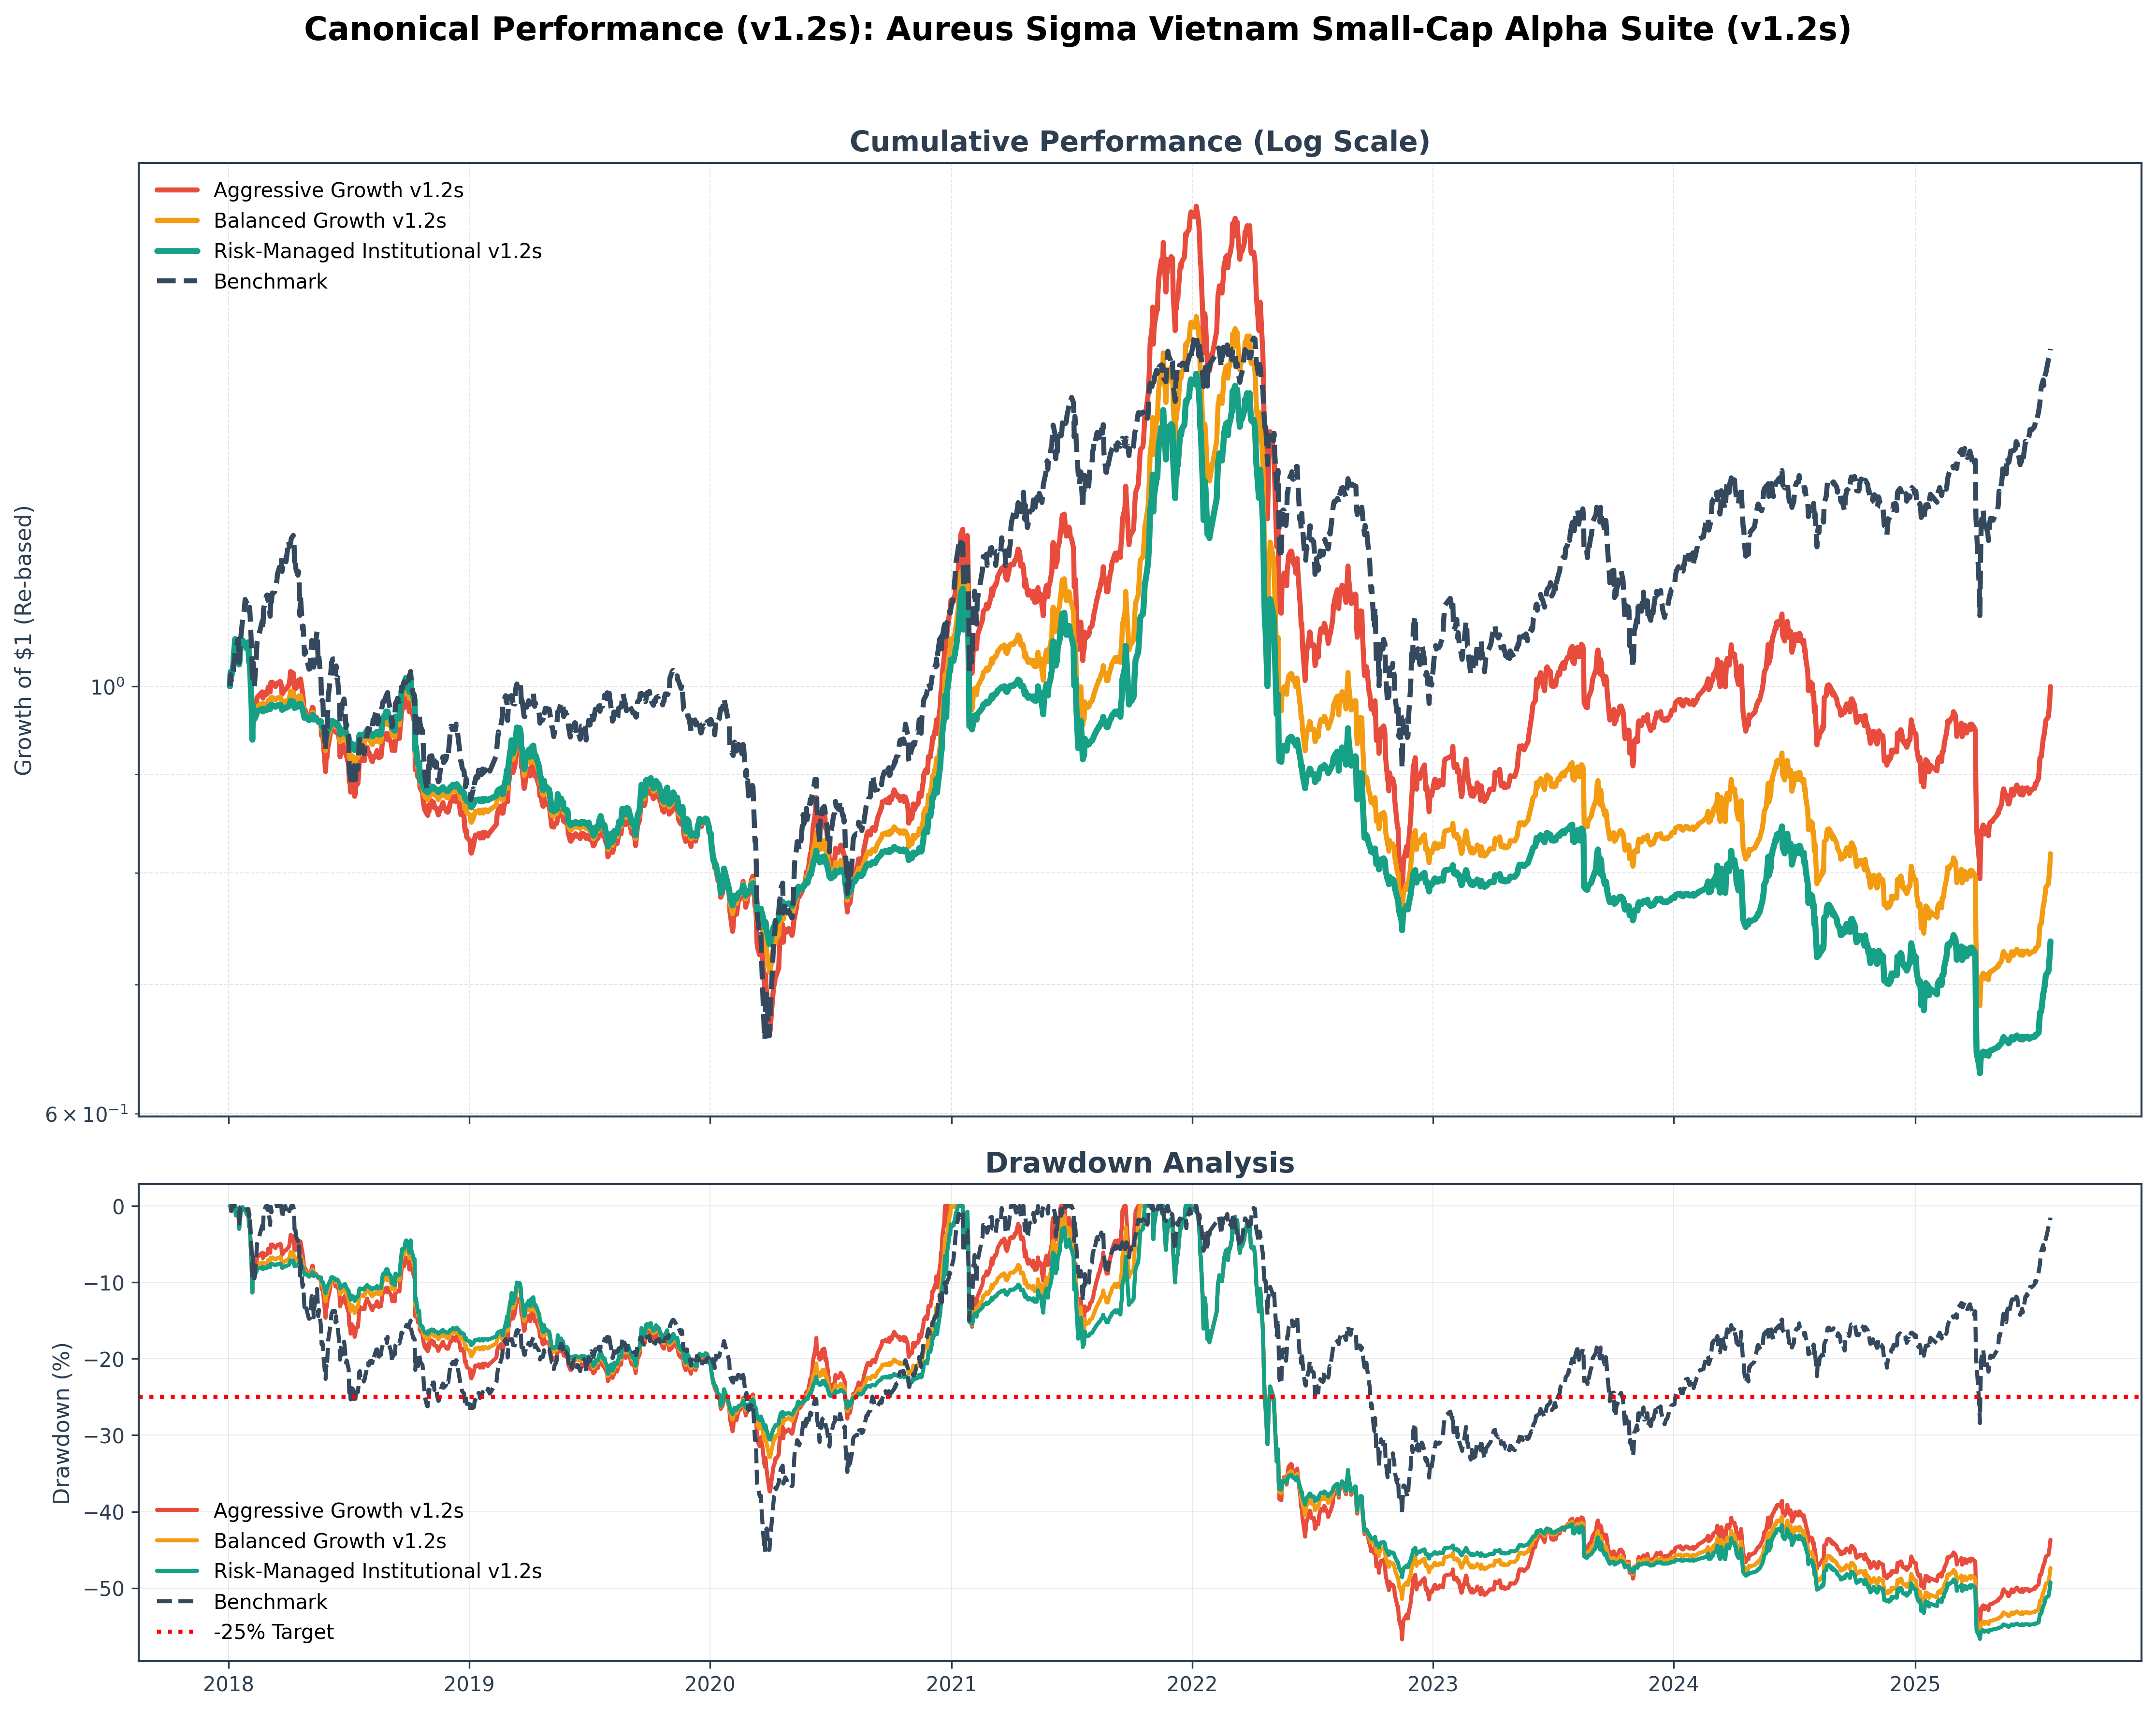


CANONICAL PERFORMANCE SUMMARY (v1.2s - Small-Cap): 2018-01-03 to 2025-07-25


,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio,Beta,Annual Alpha
Aggressive Growth v1.2s,0.04%,18.50%,0.00,-56.72%,0.00,0.73,-4.12%
Balanced Growth v1.2s,-2.61%,16.48%,-0.16,-56.11%,-0.05,0.58,-5.93%
Risk-Managed Institutional v1.2s,-3.96%,15.80%,-0.25,-56.65%,-0.07,0.51,-6.87%
Benchmark,5.69%,19.62%,0.29,-45.26%,0.13,1.00,0.00%


In [7]:
# ============================================================================
# CELL 4: FINAL PERFORMANCE ANALYSIS AND TEARSHEET (v1.2s)
# ============================================================================

print("📊 Generating final performance analysis for the v1.2s Small-Cap Alpha Strategies...")

# --- 1. Slice and Prepare Final Data ---
final_returns_data_v1_2s = {}
for name, data in master_analysis_data_v1_2s.items():
    final_returns_data_v1_2s[name] = data['returns'].loc[ANALYSIS_START_DATE:ANALYSIS_END_DATE]

returns_df_v1_2s = pd.DataFrame(final_returns_data_v1_2s)

# --- 2. Re-base the data for fair comparison ---
strategy_columns_v1_2s = [col for col in returns_df_v1_2s.columns if col != 'Benchmark']
true_inception_date_v1_2s = returns_df_v1_2s[strategy_columns_v1_2s].ne(0).any(axis=1).idxmax()
returns_df_rebased_v1_2s = returns_df_v1_2s.loc[true_inception_date_v1_2s:].copy()
print(f"   - Performance analysis re-based to true inception date: {true_inception_date_v1_2s.date()}")

# --- 3. Define the Final Tearsheet Function ---
# (Using the robust, self-contained functions from our previous work)
def calculate_full_performance_metrics(returns: pd.Series, benchmark: pd.Series) -> Dict[str, float]:
    common_index = returns.index.intersection(benchmark.index)
    returns, benchmark = returns.loc[common_index], benchmark.loc[common_index]
    n_years = len(returns) / 252
    annual_return = ((1 + returns).prod()) ** (1 / n_years) - 1 if n_years > 0 else 0
    annual_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0
    cumulative = (1 + returns).cumprod()
    drawdown = (cumulative / cumulative.cummax() - 1)
    max_drawdown = drawdown.min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
    beta = returns.cov(benchmark) / benchmark.var() if benchmark.var() > 0 else 0
    benchmark_annual_return = ((1 + benchmark).prod()) ** (1 / n_years) - 1 if n_years > 0 else 0
    alpha = annual_return - (beta * benchmark_annual_return)
    return {
        'Annual Return': annual_return * 100, 'Annual Volatility': annual_vol * 100,
        'Sharpe Ratio': sharpe_ratio, 'Max Drawdown': max_drawdown * 100,
        'Calmar Ratio': calmar_ratio, 'Beta': beta, 'Annual Alpha': alpha * 100
    }

def create_final_tearsheet_v1_2s(returns_df: pd.DataFrame, strategy_name: str):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    fig.suptitle(f'Canonical Performance (v1.2s): {strategy_name}', fontsize=16, fontweight='bold')
    
    cumulative_returns = (1 + returns_df).cumprod()
    cumulative_rebased = cumulative_returns.div(cumulative_returns.iloc[0])
    
    for col in cumulative_rebased.columns:
        color_key = col.replace(' v1.2s', '').replace(' Institutional', '')
        ax1.plot(cumulative_rebased.index, cumulative_rebased[col], 
                 label=col, color=STRATEGY_COLORS.get(col, STRATEGY_COLORS.get(color_key)), 
                 linestyle=('--' if col == 'Benchmark' else '-'),
                 linewidth=(3 if "Risk-Managed" in col else 2.5))
    ax1.set_yscale('log')
    ax1.set_title('Cumulative Performance (Log Scale)', fontweight='bold')
    ax1.set_ylabel('Growth of $1 (Re-based)')
    ax1.legend(loc='upper left')
    ax1.grid(True, which="both", ls="--", alpha=0.4)

    for col in cumulative_rebased.columns:
        color_key = col.replace(' v1.2s', '').replace(' Institutional', '')
        peak = cumulative_rebased[col].expanding(min_periods=1).max()
        drawdown = (cumulative_rebased[col] - peak) / peak
        ax2.plot(drawdown.index, drawdown * 100, label=col, color=STRATEGY_COLORS.get(col, STRATEGY_COLORS.get(color_key)),
                 linestyle=('--' if col == 'Benchmark' else '-'))
    ax2.axhline(-25, color='red', linestyle=':', linewidth=2, label='-25% Target')
    ax2.set_title('Drawdown Analysis', fontweight='bold')
    ax2.set_ylabel('Drawdown (%)')
    ax2.legend(loc='lower left')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- 4. Generate Tearsheet and Summary Table ---
create_final_tearsheet_v1_2s(returns_df_rebased_v1_2s, "Aureus Sigma Vietnam Small-Cap Alpha Suite (v1.2s)")

summary_metrics_v1_2s = {name: calculate_full_performance_metrics(returns_df_rebased_v1_2s[name], returns_df_rebased_v1_2s['Benchmark']) 
                         for name in returns_df_rebased_v1_2s.columns}

strategy_order_v1_2s = [
    "Aggressive Growth v1.2s",
    "Balanced Growth v1.2s",
    "Risk-Managed Institutional v1.2s",
    "Benchmark"
]
summary_df_v1_2s = pd.DataFrame(summary_metrics_v1_2s).T.loc[strategy_order_v1_2s]

print("\n" + "=" * 80)
print(f"CANONICAL PERFORMANCE SUMMARY (v1.2s - Small-Cap): {true_inception_date_v1_2s.strftime('%Y-%m-%d')} to {ANALYSIS_END_DATE}")
print("=" * 80)
display(summary_df_v1_2s.style.format({
    'Annual Return': '{:.2f}%', 'Annual Volatility': '{:.2f}%',
    'Sharpe Ratio': '{:.2f}', 'Max Drawdown': '{:.2f}%',
    'Calmar Ratio': '{:.2f}', 'Beta': '{:.2f}', 'Annual Alpha': '{:.2f}%'
}).background_gradient(cmap='viridis', subset=['Sharpe Ratio', 'Calmar Ratio', 'Annual Alpha']))